<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задачи" data-toc-modified-id="Задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задачи</a></span></li><li><span><a href="#Создание-функции-разделения-пользователей" data-toc-modified-id="Создание-функции-разделения-пользователей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание функции разделения пользователей</a></span><ul class="toc-item"><li><span><a href="#Описание-алгоритма-функции" data-toc-modified-id="Описание-алгоритма-функции-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Описание алгоритма функции</a></span></li><li><span><a href="#Тестирование-функции" data-toc-modified-id="Тестирование-функции-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тестирование функции</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Создание и тестирование функции разделения пользователей на группы

Для того чтобы мы могли проводить A/B тестирование, нам нужна функция, которая будет разделять пользователей на группы.

## Задачи

- Написать функцию разделения пользователей на произвольное количество групп;
- Протестировать функцию и сделать вывод о корректности деления пользователей.

## Создание функции разделения пользователей

In [1]:
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from tqdm import tqdm

Напишем функцию для разделения пользователей на группы тестирования. При этом функция должна удовлетворять следующим требованиям:
- Случайность попадания пользователя в определенную группу
    - Данное требование поможет обеспечить нам однородность групп до начала эксперимента
- Способ разбиения детерминирован
    - При повторном запуске эксперимента, пользователь будет попадать в одну и ту же группу
    - Также при соблюдении данного требования у пользователей не будет меняться группа в течении эксперимента
    
Для реализации такой функции, используем метод называемый хеширование с "солью"

In [2]:
def ab_split(id, salt='exp_1', n_groups=4):
    test_id = f'{str(id)}_{salt}'
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

Функция принимает на вход:
- `id` - идентификатор пользователя, 
- `salt` - та самая "соль" - строка которая будет присоединена к id
- `n_groups` - количество групп на которые мы хотим разделить всех пользователей

### Описание алгоритма функции

- С помощью функции хеширования внутри нашей функции мы находим хеш-сумму из строки, в данном случае это число в шестнадцатеричной системе счисления;
- далее переводим это число в десятеричную систему счисления;
- после чего находим остаток от деления данного числа на количество групп, тем самым получим номер группы для отдельного пользователя;

### Тестирование функции

Для тестирования нашей функции разбиения, проделаем следующие шаги:
1. Создадим датафрейм с id пользователей и значениями, сгенирированными из нормального распределения;
2. Будем делать случайные выборки из датафрейма;
3. Применим к случайной выборке функцию разделения пользователей с количеством групп = 4;
4. Выберем две произвольные группы (например 0 и 2, остальные группы в эксперименте не участвуют);
5. Проведем t-test и запишем полученный p-value в результирующий список;
6. Повторим шаги 2-5 множество раз (например 1000)

In [3]:
n = 1000000
test_df = pd.DataFrame({'id': range(n), 'value': np.random.normal(size=n)})
test_df.head()

,id,value
0,0,-0.293639
1,1,0.347411
2,2,-0.352419
3,3,-0.709620
4,4,-1.207074


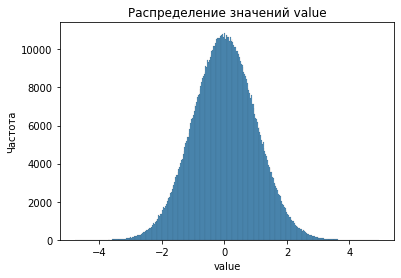

In [4]:
sns.histplot(test_df['value'])
plt.title('Распределение значений value')
plt.xlabel('value')
plt.ylabel('Частота')
plt.show()

Данный датафрейм будет нашей смоделированной генеральной совокупностью. Так как выборки будут делаться из одной и той-же совокупности, мы сможем оценить корректность деления пользователей. Проведем 1000 экспериментов и запишем их результаты в список

In [5]:
p_values = []

for i in tqdm(range(1000)):
    sample = test_df.sample(n=1000)
    sample['group'] = sample['id'].apply(ab_split)
    group_0 = sample[sample['group'] == 0]
    group_2 = sample[sample['group'] == 2]
    p_value = st.ttest_ind(group_0['value'], group_2['value'], equal_var=False).pvalue
    p_values.append(p_value)

100%|██████████| 1000/1000 [00:31<00:00, 32.01it/s]


Посмотрим на распределение значений p-value

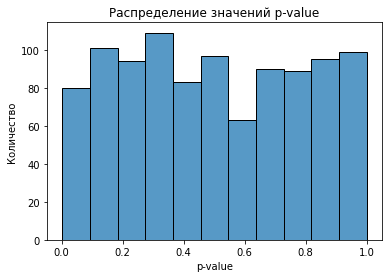

In [6]:
sns.histplot(p_values)
plt.title('Распределение значений p-value')
plt.xlabel('p-value')
plt.ylabel('Количество')
plt.show()

Распределение значений p-value стремится к равномерному. Теперь рассчитаем долю p-value которые были ниже уровня значимости в 5%. Если наша система разделения пользователей работает корректно, то доля должна быть примерно равна уровню значимости т.е. 0.05

In [7]:
p_values = pd.Series(p_values)
alpha = 0.05
(p_values < alpha).mean()

0.048

## Вывод

Доля ошибок первого рода допущенных в 1000 экспериментов составила примерно 0.05. Это значит, что наша функция деления пользователей работает корректно